In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
RISK_FREE_RATE = 0.068
EQUITY_RISK_PREMIUM = 0.055
FILE_PATH = "TRP_TVBET_Analysis_Final.xlsx"
EXCLUDED_SHEETS = ["Monthly_1Y", "Monthly_2Y"]

In [3]:
try:
    xls = pd.ExcelFile(FILE_PATH)
except FileNotFoundError:
    print(f"Error: Could not find '{FILE_PATH}'. Run the previous download script first.")
    exit()

In [4]:
results_list = []
plot_data = {}

print(f"{'TIMEFRAME':<15} | {'BETA':<10} | {'ALPHA':<10} | {'R-SQUARED':<10}")
print("-" * 60)

for sheet_name in xls.sheet_names:
    if sheet_name in EXCLUDED_SHEETS:
        continue
    try:
        freq, year_str = sheet_name.split('_')
        year = int(year_str.replace('Y', ''))
    except ValueError:
        continue
    df = pd.read_excel(xls, sheet_name=sheet_name, index_col=0)
    returns = df.pct_change().dropna()
    try:
        stock_col = [c for c in returns.columns if 'TRP' in c][0]
        market_col = [c for c in returns.columns if 'TVBET' in c][0]
        y = returns[stock_col]
        x = returns[market_col]
    except IndexError:
        continue
    beta, alpha = np.polyfit(x, y, 1)
    correlation = np.corrcoef(x, y)[0, 1]
    r_squared = correlation ** 2
    entry = {
        'Frequency': freq,
        'Years': year,
        'Sheet': sheet_name,
        'Beta': beta,
        'Alpha': alpha,
        'R_Squared': r_squared,
        'Obs': len(returns),
        'X': x,
        'Y': y
    }
    results_list.append(entry)
    plot_data[sheet_name] = entry
    print(f"{sheet_name:<15} | {beta:.4f}     | {alpha:.5f}    | {r_squared:.4f}")

TIMEFRAME       | BETA       | ALPHA      | R-SQUARED 
------------------------------------------------------------
Daily_1Y        | 1.1451     | -0.00071    | 0.2581
Weekly_1Y       | 1.4314     | -0.00584    | 0.3577
Daily_2Y        | 0.9244     | -0.00083    | 0.2145
Weekly_2Y       | 1.1431     | -0.00544    | 0.2717
Daily_3Y        | 0.6012     | -0.00056    | 0.1169
Weekly_3Y       | 1.0805     | -0.00509    | 0.2529
Monthly_3Y      | 1.4800     | -0.03497    | 0.4171
Daily_4Y        | 0.8959     | -0.00113    | 0.2199
Weekly_4Y       | 1.4633     | -0.00762    | 0.3852
Monthly_4Y      | 1.4725     | -0.03592    | 0.4601
Daily_5Y        | 0.9277     | -0.00019    | 0.1816
Weekly_5Y       | 1.5068     | -0.00331    | 0.3381
Monthly_5Y      | 1.6752     | -0.01805    | 0.3131


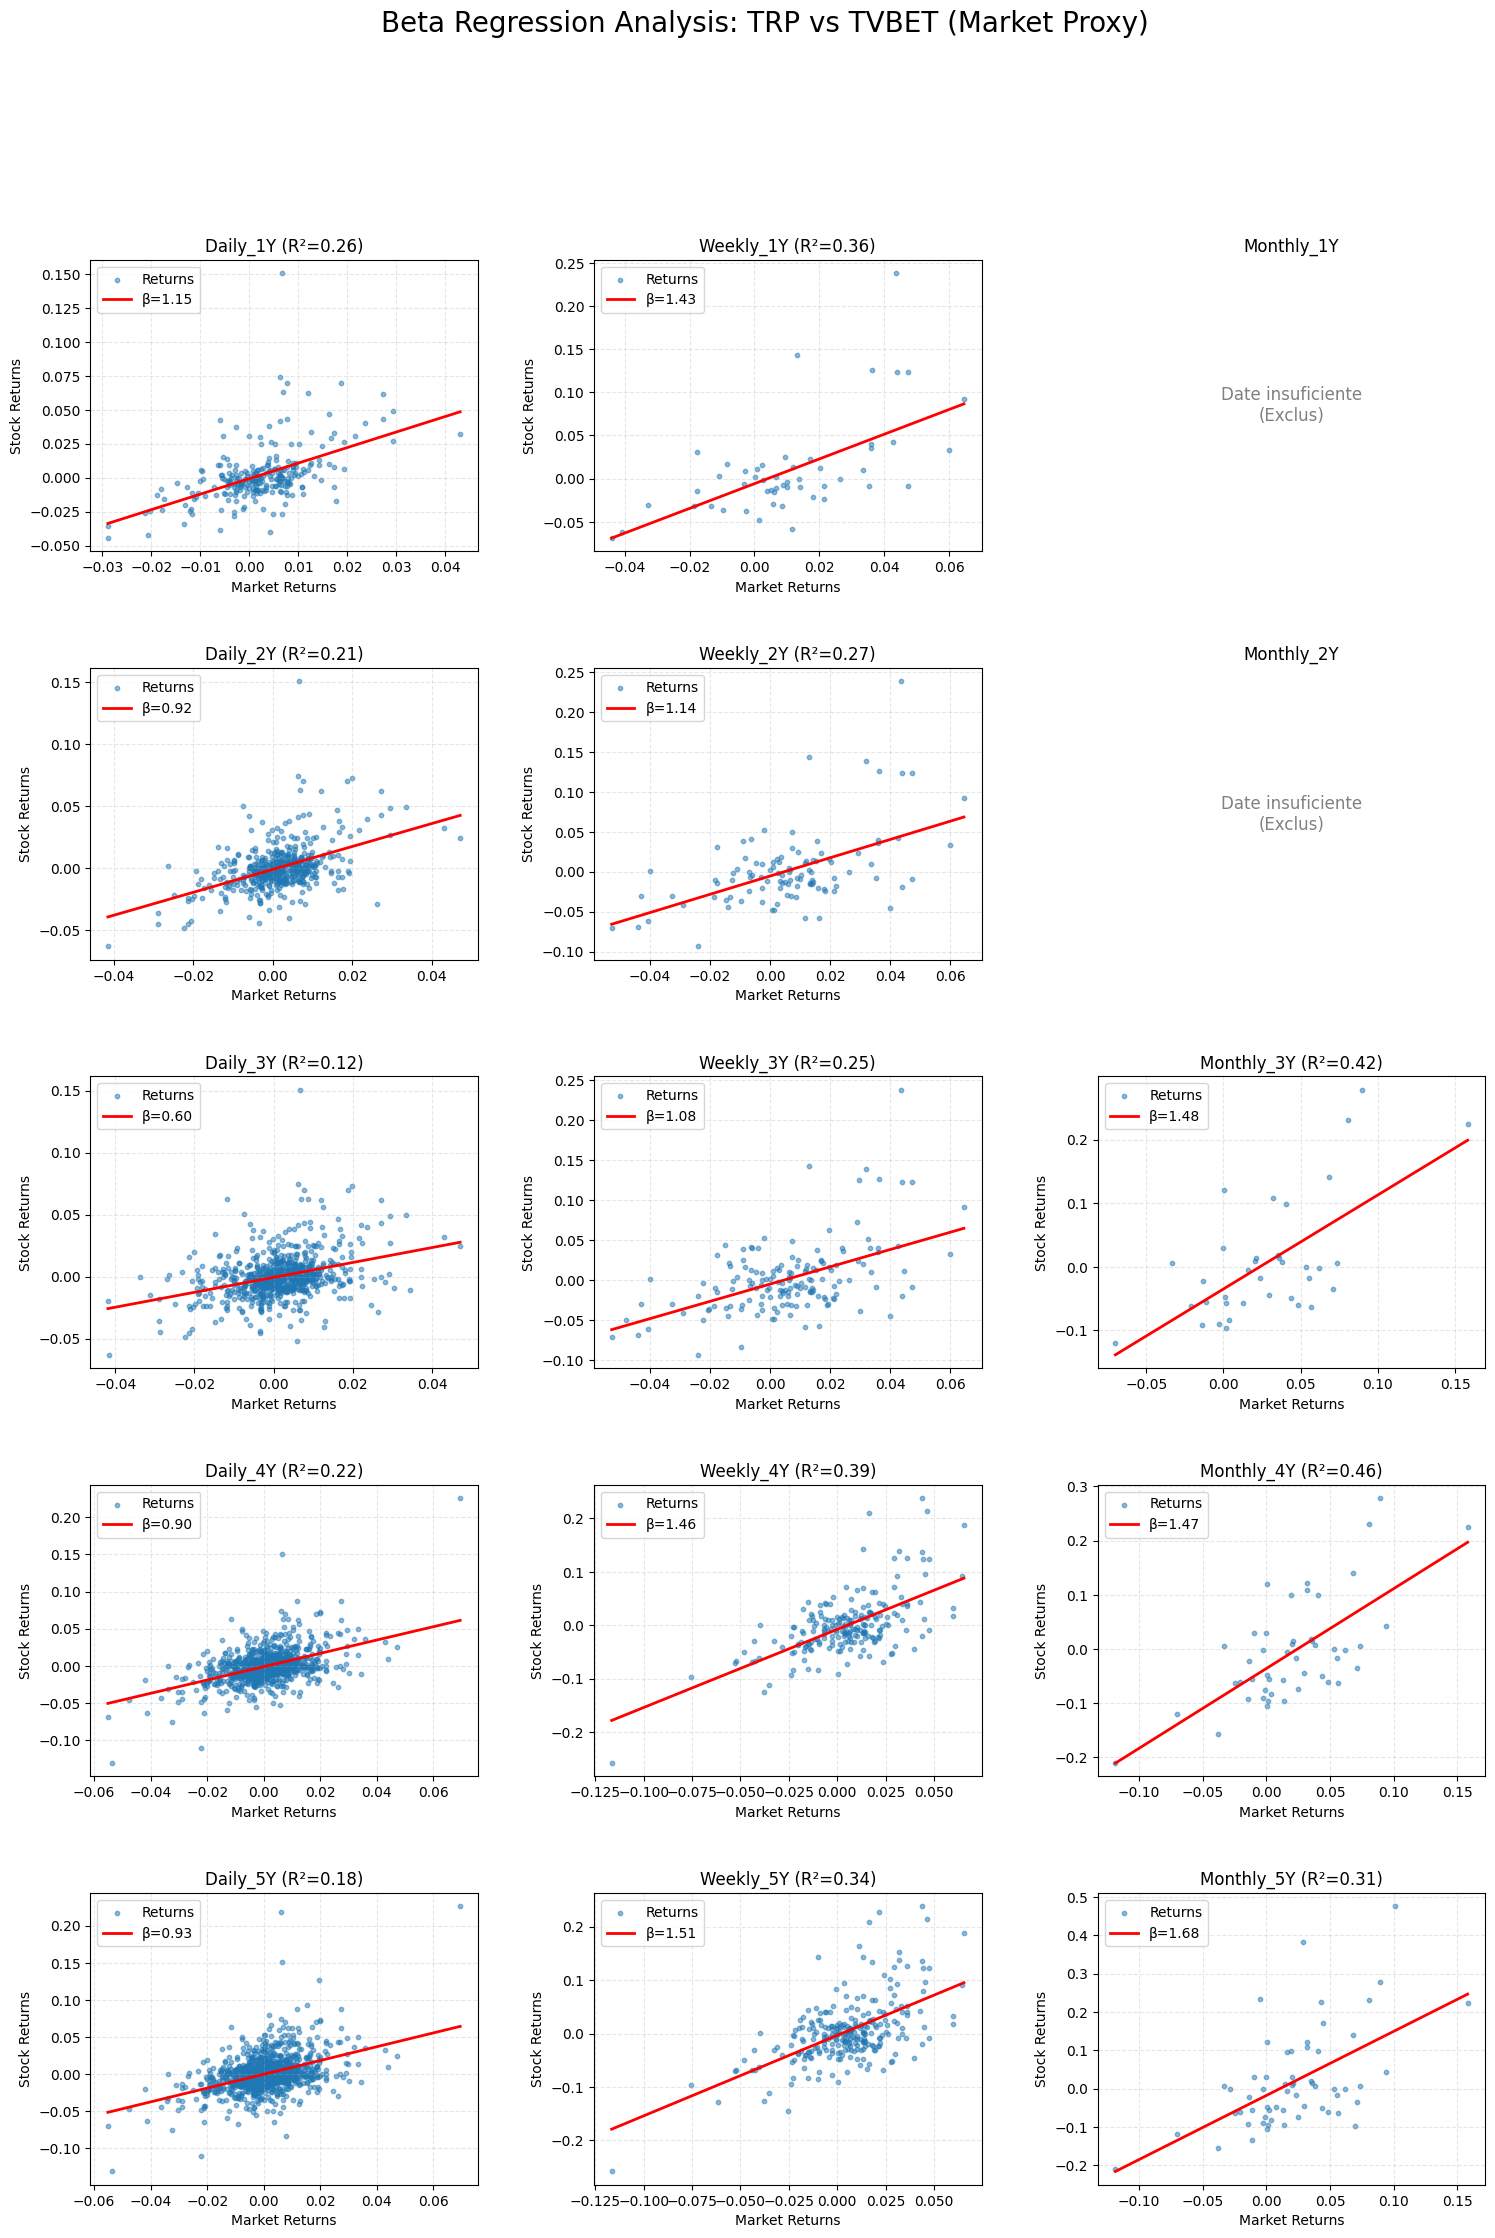

In [5]:
fig, axes = plt.subplots(5, 3, figsize=(18, 25))
fig.suptitle(f'Beta Regression Analysis: TRP vs TVBET (Market Proxy)', fontsize=20)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
freq_col_map = {'Daily': 0, 'Weekly': 1, 'Monthly': 2}

for year in range(1, 6):
    for freq in ['Daily', 'Weekly', 'Monthly']:
        sheet_name = f"{freq}_{year}Y"
        row_idx = year - 1
        col_idx = freq_col_map.get(freq, 0)
        ax = axes[row_idx, col_idx]
        if sheet_name in EXCLUDED_SHEETS:
            ax.text(0.5, 0.5, 'Date insuficiente\n(Exclus)',
                    ha='center', va='center', fontsize=12, color='gray')
            ax.set_title(sheet_name)
            ax.set_axis_off()
            continue
        if sheet_name in plot_data:
            data = plot_data[sheet_name]
            x = data['X']
            y = data['Y']
            beta = data['Beta']
            alpha = data['Alpha']
            r_squared = data['R_Squared']
            ax.scatter(x, y, alpha=0.5, s=10, label='Returns')
            x_range = np.linspace(x.min(), x.max(), 100)
            y_pred = alpha + beta * x_range
            ax.plot(x_range, y_pred, color='red', linewidth=2, label=f'β={beta:.2f}')
            ax.set_title(f"{sheet_name} (R²={r_squared:.2f})")
            ax.set_xlabel("Market Returns")
            ax.set_ylabel("Stock Returns")
            ax.legend(loc='upper left')
            ax.grid(True, linestyle='--', alpha=0.3)
        else:
            ax.set_axis_off()

In [8]:
results_df = pd.DataFrame(results_list)
if not results_df.empty:
    median_beta = results_df['Beta'].median()
    cost_of_equity = RISK_FREE_RATE + median_beta * EQUITY_RISK_PREMIUM
    print(results_df[['Sheet', 'Beta', 'R_Squared']].sort_values(by='Beta', ascending=False).to_string(index=False))
    print(f"\nMedian Beta: {median_beta:.4f}")
    print(f"Risk-Free Rate:         {RISK_FREE_RATE:.2%}")
    print(f"Equity Risk Premium:    {EQUITY_RISK_PREMIUM:.2%}")
    print(f"CAPM COST OF EQUITY:    {cost_of_equity:.2%}")

     Sheet     Beta  R_Squared
Monthly_5Y 1.675159   0.313139
 Weekly_5Y 1.506793   0.338062
Monthly_3Y 1.480023   0.417145
Monthly_4Y 1.472527   0.460117
 Weekly_4Y 1.463316   0.385180
 Weekly_1Y 1.431428   0.357742
  Daily_1Y 1.145129   0.258149
 Weekly_2Y 1.143090   0.271706
 Weekly_3Y 1.080549   0.252922
  Daily_5Y 0.927683   0.181577
  Daily_2Y 0.924402   0.214495
  Daily_4Y 0.895863   0.219903
  Daily_3Y 0.601213   0.116864

Median Beta: 1.1451
Risk-Free Rate:         6.80%
Equity Risk Premium:    5.50%
CAPM COST OF EQUITY:    13.10%
